In [26]:
using Plots
using HDF5, JLD

In [32]:
a = 0.3
Ntr = 300
sample_arr = 1:34 # [i for i in 1:100]
bond_dim_array = [i for i in 2:30]

x_test = []
x_train = []

train_last = Array{Float64}(undef, length(bond_dim_array), length(sample_arr))
valid_last = Array{Float64}(undef, length(bond_dim_array), length(sample_arr))
test_last  = Array{Float64}(undef, length(bond_dim_array), length(sample_arr))
valid_best = Array{Float64}(undef, length(bond_dim_array), length(sample_arr))
test_at_best_valid  = Array{Float64}(undef, length(bond_dim_array), length(sample_arr))


not_finished = 0

for (i, chi) in enumerate(bond_dim_array)
    for (j, sample) in enumerate(sample_arr)
        name = "Point_losses_Ntr_$(Ntr)_a_$(a)_chi_$(chi)_sample_$(sample)"
        filename = "a_03_Ntr_$(Ntr)/results/" * name * ".jld"
        check_file = "a_03_Ntr_$(Ntr)/results/Full_optim_losses_Ntr_$(Ntr)_a_$(a)_chi_$(chi)_init_backslash_sample_$(sample).jld"
        if isfile(filename)
            (last_train, last_valid, last_test, best_valid, test_corresp_to_best_valid) = jldopen(filename, "r") do file
#                 (x_test, test_losses, x_train, train_losses) = jldopen(filename, "r") do file
            f = read(file, name);
            end
            train_last[i,j] = last_train
            valid_last[i,j] = last_valid
            test_last[i,j]  = last_test
            valid_best[i,j] = best_valid
            test_at_best_valid[i,j] = test_corresp_to_best_valid
        else
            not_finished += 1
            print("not finished $(not_finished) \r")
        end
    end
end

In [33]:
name = "pseudoinv_losses_Ntr_$(Ntr)_a_$(a)"
path = "../7_Fitting_exact_inv/Different_Ntr/Results/" * name
f = jldopen(path, "r") do file
        read(file, name)
end

m_test_results = f["test mean"]
std_test_results = f["test std"];
# m_train_results = f["train mean"]
# std_train_results = f["train std"];

In [34]:
function getMeanStd(arr)
    d1, d2 = size(arr)
    mean_arr = Array{Float64}(undef, d1)
    median_arr = Array{Float64}(undef, d1)
    std_arr  = Array{Float64}(undef, d1)
    
    # get mean and median
    for i in 1:d1
        m = 0
        counter = 0
        for j in 1:d2
            number = arr[i,j]
            if ! isnan(number) && number > 1e-20
                m += number
                counter += 1
            end
        end
        if counter > 0
            mean_arr[i] = m / counter
        end
        s = sort(arr[i, : ])
        median_arr[i] = s[ div(length(arr[i,:]), 2) ]
    end
    
    # get std
    for i in 1:d1
        std = 0
        counter = 0
        for j in 1:d2
            number = arr[i,j]
            if ! isnan(number) && number > 1e-20
                std += (mean_arr[i] - number)^2
                counter += 1
            end
        end
        if counter > 0
            std_arr[i] = sqrt(std / counter)
        end
    end
    
    return mean_arr, median_arr, std_arr
end;

In [35]:
train_last_mean, train_last_median, train_last_std = getMeanStd(train_last)

valid_last_mean, valid_last_median, valid_last_std = getMeanStd(valid_last)
valid_best_mean, valid_best_median, valid_best_std = getMeanStd(valid_best)

test_last_mean, test_last_median, test_last_std = getMeanStd(test_last)
test_at_best_valid_mean, test_at_best_valid_median, test_at_best_validt_std = getMeanStd(test_at_best_valid);

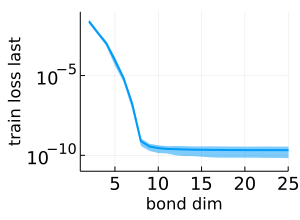

In [36]:
plot()
plot!(bond_dim_array, train_last_mean, ribbon=(train_last_std, train_last_std), 
    yaxis =:log, 
    xtickfont = font(12, "Arial"), ytickfont = font(12, "Arial"), 
    label = "", 
    linewidth = 2, xticks = [i for i in 5:5:25]) 

ylims!(1e-11, 1e-1)
xlims!(1, 25)
plot!(size=(300, 220), xlabel = "bond dim", 
        ylabel ="train loss last", 
        legend =:topright)#, yticks = [5,6,7])

In [37]:
# savefig("train.pdf")

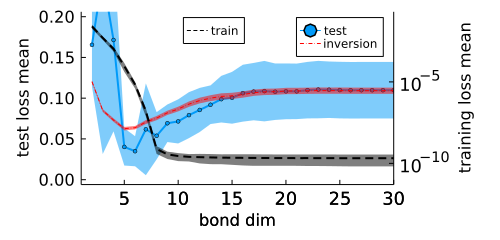

In [38]:
plot()

plot!(bond_dim_array, test_at_best_valid_mean, 
      ribbon=(test_at_best_validt_std, test_at_best_validt_std), 
      xtickfont = font(12, "Arial"), ytickfont = font(12, "Arial"), 
      tickfontsize = 11, 
      label = "test", linewidth = 2, grid = :off, # at best valid
      left_margin = 5Plots.mm, right_margin = 25Plots.mm, 
      bottom_margin = 5Plots.mm, marker = :o, ylims = [0.0, 0.2], 
      markersize = 2)

# plot!(bond_dim_array, test_last_mean, ribbon=(test_last_std, test_last_std), 
#     xtickfont = font(12, "Arial"), ytickfont = font(12, "Arial"), 
#     label = "last", linewidth = 2, legend =:top) #, marker ="o")

plot!(bond_dim_array, m_test_results, ribbon=(std_test_results, std_test_results), 
        label = "inversion", linewidth = 1, linestyle = :dashdot, 
        color = "red", ylabel = "test loss mean", )

# plot!([i for i in 1:30], m_test_results, ribbon=(std_test_results, std_test_results), 
#         label = "inversion", linewidth = 1, linestyle = :dashdot, 
#         color = "red", ylabel = "test loss mean", )


plot!(twinx(), bond_dim_array, train_last_mean, linestyle = :dash, yaxis =:log, 
    ribbon=(train_last_std, train_last_std), 
    xtickfont = font(12, "Arial"), ytickfont = font(12, "Arial"), color = "black",
    label = "train", linewidth = 2, ylims = [1e-11, 1e-1], legend =:top,
    ylabel = "training loss mean", ) 

# ylims!(0.0, 0.2)
xlims!(1, 30)
plot!(size=(500, 240), xlabel = "bond dim", 
        xticks = [i for i in 5:5:30])#, yticks = [5,6,7])

In [39]:
savefig("optim_res_a_$(a).pdf")

In [10]:
# plot()

# plot!(bond_dim_array, test_at_best_valid_median, 
#       ribbon=(test_at_best_validt_std, test_at_best_validt_std), 
#       xtickfont = font(12, "Arial"), ytickfont = font(12, "Arial"), 
#       tickfontsize = 11, 
#       label = "at best valid", linewidth = 2, grid = :off, 
#       left_margin = 5Plots.mm, right_margin = 25Plots.mm, 
#       bottom_margin = 5Plots.mm, ylims = [0.0, 0.2], marker = :o,
#       markersize = 2)

# plot!(bond_dim_array, test_last_median, ribbon=(test_last_std, test_last_std), 
#     xtickfont = font(12, "Arial"), ytickfont = font(12, "Arial"), 
#     label = "last", linewidth = 2, legend =:top) #, marker ="o")

# plot!(bond_dim_array, m_test_results, ribbon=(std_test_results, std_test_results), 
#         label = "inversion", linewidth = 1, linestyle = :dashdot, 
#         color = "red", ylabel = "test loss median", )

# plot!(twinx(), bond_dim_array, train_last_median, linestyle = :dash, yaxis =:log, 
#     ribbon=(train_last_std, train_last_std), 
#     xtickfont = font(12, "Arial"), ytickfont = font(12, "Arial"), color = "black",
#     label = "test", linewidth = 2, ylims = [1e-11, 1e-1], legend =:topright,
#     ylabel = "training loss median", ) 

# # ylims!(0.0, 0.2)
# xlims!(1, 30)
# plot!(size=(500, 240), xlabel = "bond dim", 
        
#         xticks = [i for i in 5:5:30])#, yticks = [5,6,7])

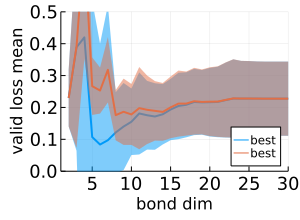

In [11]:
plot()

plot!(bond_dim_array, valid_best_mean, ribbon=(valid_last_std, valid_last_std),  # ribbon=(2*test_best_std, 2*test_best_std), 
#     xtickfont = font(12, "Arial"), ytickfont = font(12, "Arial"), 
    tickfontsize = 11, 
    label = "best", linewidth = 2) #, marker ="o")

plot!(bond_dim_array, valid_last_mean, ribbon=(valid_best_std, valid_best_std),  # ribbon=(2*test_last_std, 2*test_last_std), 
    xtickfont = font(12, "Arial"), ytickfont = font(12, "Arial"), 
    label = "best", linewidth = 2) #, marker ="o")

ylims!(0.0, 0.5)
xlims!(1, 30)
plot!(size=(300, 220), xlabel = "bond dim", 
        ylabel ="valid loss mean", legend =:bottomright, 
        xticks = [i for i in 5:5:30])#, yticks = [5,6,7])

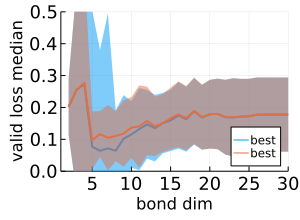

In [12]:
plot()

plot!(bond_dim_array, valid_best_median, ribbon=(valid_last_std, valid_last_std),  # ribbon=(2*test_best_std, 2*test_best_std), 
#     xtickfont = font(12, "Arial"), ytickfont = font(12, "Arial"), 
    tickfontsize = 11, 
    label = "best", linewidth = 2) #, marker ="o")

plot!(bond_dim_array, valid_last_median, ribbon=(valid_best_std, valid_best_std),  # ribbon=(2*test_last_std, 2*test_last_std), 
    xtickfont = font(12, "Arial"), ytickfont = font(12, "Arial"), 
    label = "best", linewidth = 2) #, marker ="o")

ylims!(0.0, 0.5)
xlims!(1, 30)
plot!(size=(300, 220), xlabel = "bond dim", 
        ylabel ="valid loss median", legend =:bottomright, 
        xticks = [i for i in 5:5:30])#, yticks = [5,6,7])

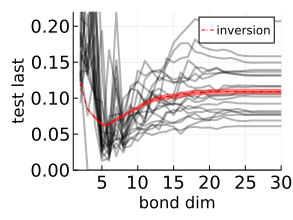

In [66]:
plot()
for i in 1:20

    plot!(bond_dim_array, test_last[:,i], #ribbon=(2*test_best_std, 2*test_best_std), 
#         xtickfont = font(12, "Arial"), ytickfont = font(12, "Arial"), 
    label = "", color = "black", alpha = 0.3, linewidth = 2, tickfontsize = 12) #, marker ="o")
    
end

plot!(bond_dim_array, m_test_results, ribbon=(std_test_results, std_test_results), 
        label = "inversion", linewidth = 1, linestyle = :dashdot, 
        color = "red", ylabel = "test loss mean", )

ylims!(0, 0.22)
xlims!(1, 30)
plot!(size=(293, 220), xlabel = "bond dim", 
        ylabel ="test last", legend =:topright, 
        xticks = [i for i in 5:5:30])#, yticks = [5,6,7])

In [14]:
# savefig("test.pdf")

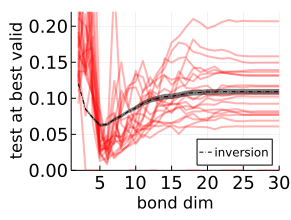

In [68]:
plot()
for i in 1:20
    plot!(bond_dim_array, test_at_best_valid[:,i], #ribbon=(2*test_best_std, 2*test_best_std), 
        xtickfont = font(12, "Arial"), ytickfont = font(12, "Arial"), 
        label = "", color = "red", alpha = 0.3, linewidth = 2) #, marker ="o")
    
#     plot!(bond_dim_array, test_last[:,i], #ribbon=(2*test_best_std, 2*test_best_std), 
# #         xtickfont = font(12, "Arial"), ytickfont = font(12, "Arial"), 
#     label = "", color = "black", alpha = 0.5, linewidth = 2, tickfontsize = 12) #, marker ="o")
    
end

plot!(bond_dim_array, m_test_results, ribbon=(std_test_results, std_test_results), 
        label = "inversion", linewidth = 1, linestyle = :dashdot, 
        color = "black", ylabel = "test loss mean", )


ylims!(0, 0.22)
xlims!(1, 30)
plot!(size=(291, 220), xlabel = "bond dim", 
        ylabel ="test at best valid", legend =:bottomright, 
        xticks = [i for i in 5:5:30])#, yticks = [5,6,7])

In [16]:
# savefig("test.pdf")

In [17]:
chi = 4
sample = 2

name = "Full_optim_losses_Ntr_$(Ntr)_a_$(0.3)_chi_$(chi)_init_backslash_sample_$(sample)"
filename = "a_03_Ntr_$(Ntr)/results/" * name * ".jld"
if isfile(filename)
    (x_test, test_losses, x_train, train_losses) = jldopen(filename, "r") do file
    f = read(file, name)
    end
else
    println("No such file")
end;

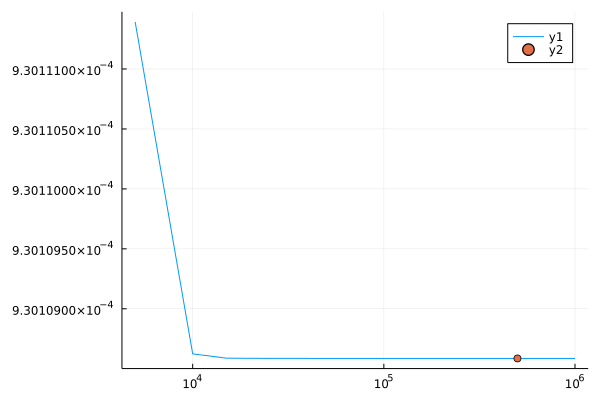

In [18]:
x = 100
plot(x_train[2:end], train_losses[2:end], xaxis =:log)
scatter!([x_train[end-x]], [train_losses[end-x]])
# ylims!(1e-10, 1e-5)

In [19]:
abs(train_losses[end] - train_losses[end-x]) / train_losses[end]

5.828363425530413e-16

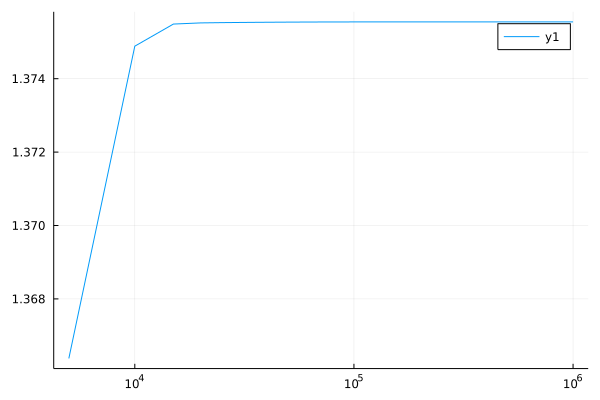

In [20]:
plot(x_test[2:end], test_losses[2:end], xaxis=:log)

In [21]:
(test_losses[end-x] - test_losses[end]) /  test_losses[end] * 100

-1.7110818740947753e-12

In [22]:
chi = 2

tests = []
trainings = []

for sample in 1:30
    name = "Full_optim_losses_Ntr_$(Ntr)_a_$(0.3)_chi_$(chi)_init_backslash_sample_$(sample)"
    filename = "a_03_Ntr_$(Ntr)/results/" * name * ".jld"
    if isfile(filename)
        (x_test, test_losses, x_train, train_losses) = jldopen(filename, "r") do file
        f = read(file, name)
        end
        tests = vcat(tests, [test_losses])
        trainings = vcat(trainings, [train_losses])
    else
        println("No such file")
    end
end

No such file
No such file
No such file
No such file
No such file
No such file
No such file
No such file
No such file
No such file
No such file
No such file
No such file


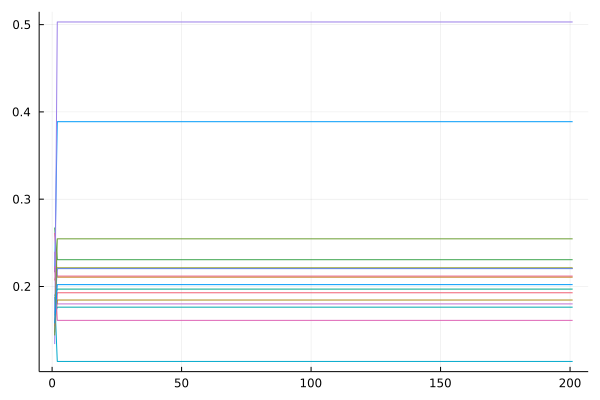

In [23]:
plot(tests, label = "")

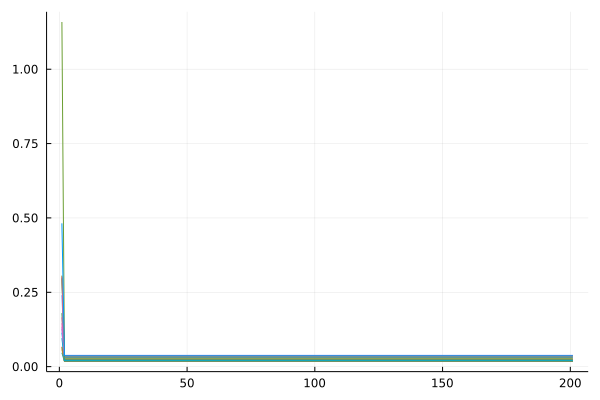

In [24]:
plot(trainings, label = "")
# ylims!(1e-5, 1e-4)